## Introduction

Need to answer the questions:
- What is the machine learning problem you are trying to solve?
- Why does the problem matter?
- What could the results of your predictive model be used for?
- Why would we want to be able to predict the thing you're trying to preduct?
- Describe the dataset.

We can use the music composition of the song (acousticness, speechiness, key) to predict its popularity and the number of streams that it will have.

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv("spotify-2023.csv", thousands=',')
raw_data = data

### 1. Data Prep
#### 1.1 Data Cleaning
Impute missing values 
- Missing keys:
    
    On review of the songs with missing keys, a majority are C, so all missing keys have been entered as C.
- Missing in_shazam_charts rankings:
    
    Imputing a value of 0, as these songs most likely did not land in shazam charts. And modify datatype to integer like other in_*_charts features.

In [3]:
# Fill in NaNs in the key column with C and the NaNs in in_shazam_charts with 0
data['key'] = data['key'].fillna("C")
data['in_shazam_charts'] = data['in_shazam_charts'].fillna(0).astype('int')

# Ensure no more NaNs in data
data.isnull().values.any()

False

One-Hot encode categorical values
- Key
- Mode

In [4]:
# Modify keys
one_hot = pd.get_dummies(data['key'])
data = data.drop('key',axis = 1)
data = data.join(one_hot)

# Modify modes -- binary: Minor vs not-minor
one_hot = pd.get_dummies(data['mode'], drop_first=True)
data = data.drop('mode',axis = 1)
data = data.join(one_hot)

print(data.head())

                            track_name    artist(s)_name  artist_count  \
0  Seven (feat. Latto) (Explicit Ver.)  Latto, Jung Kook             2   
1                                 LALA       Myke Towers             1   
2                              vampire    Olivia Rodrigo             1   
3                         Cruel Summer      Taylor Swift             1   
4                       WHERE SHE GOES         Bad Bunny             1   

   released_year  released_month  released_day  in_spotify_playlists  \
0           2023               7            14                   553   
1           2023               3            23                  1474   
2           2023               6            30                  1397   
3           2019               8            23                  7858   
4           2023               5            18                  3133   

   in_spotify_charts    streams  in_apple_playlists  ...      C     C#      D  \
0                147  141381703          

#### 1.2 Data Exploration

The goal is to find what features may have the largest affect on the number of streams and the popularity of a song. 
One of the easiest ways to see this is through a correlation chart.

In [5]:
# Notable correlations with streams: 
#   in_spotify_playlists, in_apple_playlists, in_apple_charts, in_spotify_charts
data.corrwith(data['streams'], numeric_only=True)

artist_count           -0.135791
released_year          -0.224320
released_month         -0.023571
released_day            0.011907
in_spotify_playlists    0.789730
in_spotify_charts       0.246247
streams                 1.000000
in_apple_playlists      0.772156
in_apple_charts         0.320888
in_deezer_playlists     0.598127
in_deezer_charts        0.228894
in_shazam_charts       -0.006090
bpm                    -0.002015
danceability_%         -0.104462
valence_%              -0.041738
energy_%               -0.026308
acousticness_%         -0.003754
instrumentalness_%     -0.044705
liveness_%             -0.048233
speechiness_%          -0.111577
A                      -0.056823
A#                      0.017307
B                       0.003090
C                       0.004457
C#                      0.060752
D                       0.008566
D#                      0.013183
E                       0.029752
F                      -0.025584
F#                      0.004453
G         

Description & Distribution of the number of streams across songs.

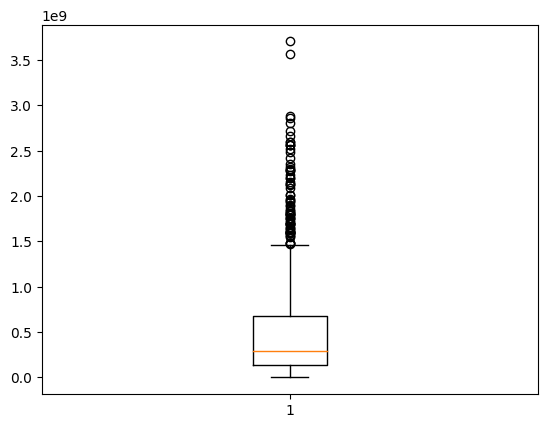

count    9.530000e+02
mean     5.136038e+08
std      5.667986e+08
min      2.762000e+03
25%      1.413817e+08
50%      2.902286e+08
75%      6.738011e+08
max      3.703895e+09
Name: streams, dtype: float64

In [6]:
plt.boxplot(data['streams'])
plt.show()

data['streams'].describe()

Checking the distribution of some factors we might expect to have an affect on popularity

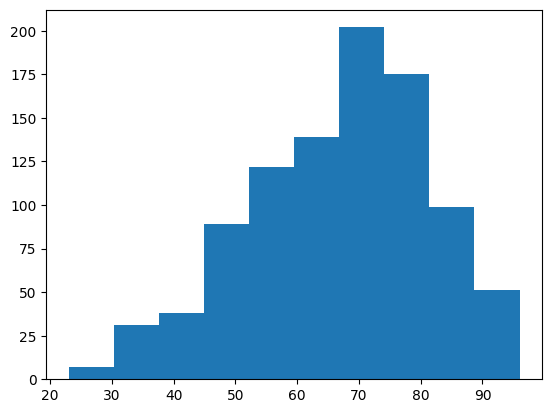

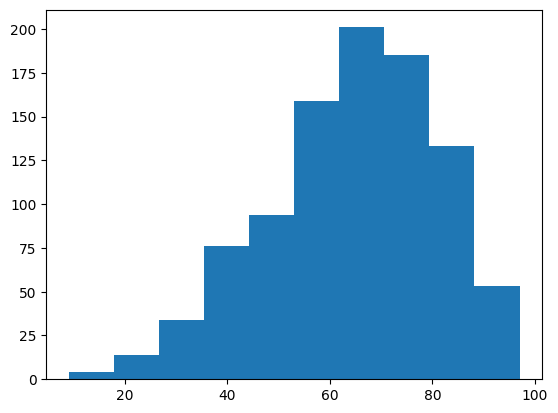

In [7]:
plt.hist(data['danceability_%'])
plt.show()
plt.hist(data['energy_%'])
plt.show()

Does the mode of the song have any affect on the number of streams?

What about the song's bpm on chart rankings?

In [8]:
# Mode has a minor affect on the number of streams
print(data.groupby(by=['Minor'])['streams'].mean())

# Some BPMs seem a lot more popular than others.
# notable bpms to appear in charts multiple times (>10):
#   90, 92, 94, 96, 100, 105, 110, 120, 130, 140, 170
pd.options.display.max_rows = 150
data[data['in_spotify_charts'] > 0].groupby(by=['bpm'])['in_spotify_charts'].count()

Minor
False    5.338706e+08
True     4.859445e+08
Name: streams, dtype: float64


bpm
67      1
71      1
72      1
74      1
76      1
77      1
78      3
79      2
80      3
81      3
82      3
83      3
84      3
85      4
87      1
88      4
89      2
90     14
91      2
92     16
93      9
94     11
95     10
96     11
97      4
98     10
99      4
100    11
101     5
102     5
103     4
104     3
105    13
106     1
107     7
108     6
109     3
110    13
111     1
112     4
113     2
114     6
115     6
116     7
117     7
118     6
119     2
120    23
121     5
122    10
123     6
124     9
125    10
126     4
127     2
128    10
129     4
130    25
131     2
132     6
133     5
134     7
135     6
136     6
137     3
138     4
139     5
140    20
141     3
142     5
143     3
144     9
145     6
146     6
147     1
148     4
149     2
150    10
152     1
153     1
154     5
155     2
156     2
157     1
158     3
160     4
161     1
162     1
163     1
164     2
165     1
166     3
168     3
169     2
170    12
171     2
172     5
173     2
174     6
175   

#### 1.3 Feature Engineering
- Remove track & artist names.

    All track names are going to be different. Using artist names would inflate the number of dimensions, which seems to have diminishing returns since most artists are different.


In [9]:
# Remove artist names, track name
data = data.drop(['track_name', 'artist(s)_name'], axis=1)

### 2. Modeling
- Describe process and models tested
- Going to test linear regression & KNN

#### Linear Regression
We first start with a linear regression model since it is simple and computationally efficient. Linear regression acts as a baseline that can give us insights into the complexity of the dataset and guide further modeling choices.

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# simple modeling with streams and in_spotify
spotify = data["in_spotify_playlists"]
streams = data["streams"]
spotify = spotify.values.reshape(-1, 1)
streams = streams.values.reshape(-1, 1)
reg = LinearRegression()

r = cross_val_score(estimator=reg, X=spotify, y=streams, cv=5)
print("Simple regression on in_spotify_playlists vs streams: ")
print("Average R2: " + str(r.mean()))
print("Adjusted R2: " + str((1 - (1 - r) * ((spotify.shape[0] - 1) / 
          (spotify.shape[0] - spotify.shape[1] - 1))).mean()))

reg = LinearRegression()

# streams = data["streams"]
x=data.loc[:, data.columns != 'streams']
# x.apply(pd.to_numeric)


r = cross_val_score(estimator=reg, X=x, y=streams, cv=5, error_score='raise')
print("\nRegression on the entire dataset: ")

print("Average R2: " + str(r.mean()))
print("Adjusted R2: " + str((1 - (1 - r) * ((x.shape[0] - 1) / 
          (x.shape[0] - x.shape[1] - 1))).mean()))

Simple regression on in_spotify_playlists vs streams: 
Average R2: 0.48735618013674403
Adjusted R2: 0.48681712249230313

Regression on the entire dataset: 
Average R2: 0.5715590311603842
Adjusted R2: 0.5566567365920497


#### Ensemble: Random Forest Regressor
Since the R2 value of linear regression was pretty low (the regression line does not approximate the actual data well), we proceed to try ensembling with decision tree base classifiers. Decision trees can capture complex relationships between the features and labels, making them well-suited for our dataset where the true relationship may not be linear. When used in ensembling methods like random forests, decision trees can address the issue of high variance associated with individual trees. By aggregating predictions from multiple trees, random forests can provide more stable and generalizable results.

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import r2_score

# Define features and labels
features = data.loc[:, data.columns != 'streams']
labels = data["streams"]

# Define emsemble regression model
rfr = RandomForestRegressor()

# Perform Grid Search
param_grid = {
    'n_estimators': [50,100,150]
}
gs = GridSearchCV(rfr, param_grid, cv=5)
gs.fit(features, labels)

# Make predictions using cross-validated model
predictions = cross_val_predict(gs, features, labels, cv=5)

# Evaluate model
r2 = r2_score(labels, predictions)
print("R-squared Score:", r2)

R-squared Score: 0.7793078226592851


#### KNN Models
We decided to try some KNN models since a natural conclusion would be that songs of a similar make-up would end up having similar popularity. 
(For now) to achieve results the 'streams' class has been divided into the quartiles found when describing 'streams'.

In [12]:
# --- KNN Model ---

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

def quarterStreams(e):
    if e <= 141_381_700:
        return 150_000_000
    elif e <= 290_228_600:
        return 300_000_000
    elif e <= 673_801_100:
        return 700_000_000
    else: 
        return 1_000_000_000


# Separate class and features
knn_copy = data.copy()

data_features = knn_copy.drop(columns='streams')
data_class = knn_copy.loc[:, 'streams']
data_class = data_class.apply(quarterStreams)
# print(data_class.describe())

# TODO: need to turn the streams class into thresholds to get rid of the n_splits error
# for now rounding based on quartiles
# 25%    <=  1.413817e+08 -> 150000000
# 50%    <=  2.902286e+08 -> 300000000
# 75%    <=  6.738011e+08 -> 700000000
# and one for greater than   700000000

# Create pipeline
stdsc = sk.preprocessing.StandardScaler()
pca = PCA()
knc = KNeighborsClassifier()
pipeline = Pipeline(steps=(('stdsc', stdsc), ('pca', pca), ('knc', knc)))

# Cross validation
cvs = cross_val_score(pipeline, data_features, data_class, cv=5)
print('CROSS VAL SCORE')
print('average. ', cvs.mean())


param_grid = {
    'pca__n_components': list(range(2, 32)),
    'knc__n_neighbors': list(range(1, 25))
}

# Gridsearch 
gscv = GridSearchCV(pipeline, param_grid, cv=5)
gscv_res = gscv.fit(data_features, data_class)
print('GRID SEARCH CV')
print('best params. ', gscv_res.best_params_)
print('best score. ', gscv_res.best_score_)



CROSS VAL SCORE
average.  0.3567318820611739
GRID SEARCH CV
best params.  {'knc__n_neighbors': 23, 'pca__n_components': 3}
best score.  0.47538164783686965


### 3. Results
- Describe results of final modeling